# Цели и задачи проекта

# Первичный анализ данных
Импортируем библиотеки и прочитаем файл с данными:

In [1]:
import pandas as pd
import numpy as np
from math import nan
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

df = pd.read_csv('stud_math.csv')

df.columns = [col.lower() for col in df.columns]

Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:

In [2]:
display(df.head(20))
df.info()

#col = df['famrel']
#col.replace(nan, 'REPLACE', inplace=True)

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    float64
 7   fedu                 371 non-null    float64
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Итого 395 строк (в значениях большинства колонок есть пропуски), 30 столбцов. В датасете 13 числовых столбцов, 17 строковых.

# Функции для работы со столбцами

In [3]:
def get_absence_number(col):
    return (col.isnull() | col.isna()).sum()


def check_discrete_values(col, list_values):
    col_err = col[~col.isin(list_values) & ~col.isnull()]
    if col_err.size == 0:
        print('Данные корректны.')
    else:
        print('Данные не корректны:', col_err.value_counts())


def check_continuous_values(col, list_borders):
    # list_borders.sort()
    list_borders = sorted(list_borders)
    col_err = col[(col < list_borders[0]) | (col > list_borders[1]) & ~col.isnull()]
    if col_err.size == 0:
        print('Данные корректны.')
    else:
        print('Данные не корректны:', col_err.value_counts())


# col.replace(40, 4, inplace=True)


def remove_value(df, col_name, value):
    if (not pd.isnull(value)) and (not pd.isna(value)):
        return df[df[col_name] != value]
    else:
        return df[~(df[col_name].isnull() | df[col_name].isna())]


def get_percentiles(col):
    list_quant = [col.quantile(0.25), col.quantile(0.75)]
    iqr = list_quant[1] - list_quant[0]
    diap = [list_quant[0] - 1.5*iqr, list_quant[1] + 1.5*iqr]
    return [list_quant, diap, iqr]


def print_column_info(col):
    
    if col.nunique() > 10:
        value_counts_0 = col.value_counts().iloc[:10]
        value_counts_1 = col.value_counts(normalize=True).iloc[:10] 
    else:
        value_counts_0 = col.value_counts()
        value_counts_1 = col.value_counts(normalize=True)
        
    df_disp = pd.DataFrame({'Num': value_counts_0.values,
                            '%': 100 * np.round(value_counts_1.values,decimals=3)},
                            index = value_counts_0.index)
    display(df_disp)
    
    if col.nunique() > 10:
        print('... other values')
        
    display(sum(col.value_counts().values))
    
    print(f'Количество пропусков: {get_absence_number(col)}')
    print(f'Количество уникальных значений: {col.nunique()}')
    print(f'Количество значений, встретившихся более 10 раз: {(col.value_counts()>10).sum()}')


def print_column_hist(col, list_borders, list_borders_plot=None):
    display(col.describe())
    list_perc = get_percentiles(col)
    print(f'25-й перцентиль: {list_perc[0][0]},', f'75-й перцентиль: {list_perc[0][1]}',
          f'\nIQR: {list_perc[-1]},', f'Границы выбросов: [{list_perc[1][0]}, {list_perc[1][1]}].')
    # col.hist(bins=8, range=list_borders, label='IQR')
    if list_borders_plot == None:
        list_borders_plot = (list_borders[0] - 2, list_borders[1] + 2)
    col.loc[col.between(list_borders[0], list_borders[1])].hist(alpha=0.5,
                                                                #bins=10,
                                                                range=list_borders_plot,
                                                                label='Здравый смысл')
    col.loc[col.between(list_perc[1][0], list_perc[1][1])].hist(#bins=10,
                                                                range=list_borders_plot,
                                                                label='IQR')
    plt.legend()
    
    
def get_boxplot(df, col_name, idx=None):
    fig, ax = plt.subplots(figsize = (14, 4))
    
    if df[col_name].nunique() < 10:
        df_boxplot = df
    else:
        df_boxplot = df.loc[df.loc[:, col_name].isin(df.loc[:, col_name].value_counts().index[:10])]
        print('get_boxplot: nunique >= 10')
    
    sns.boxplot(x=col_name, y='score', data=df_boxplot, ax=ax)
    plt.xticks(rotation=45)
    
    if idx == None:
        ax.set_title('Boxplot for ' + col_name)
    else:
        ax.set_title('#' + str(idx) + ' Boxplot for ' + col_name)
        
    plt.show()
    

    
def get_stat_dif(df, col_name):
    
    if df[col_name].nunique() < 10:
        cols = df.loc[:, col_name].value_counts().index
    else:
        cols = df.loc[:, col_name].value_counts().index[:10]
    
    combinations_all = list(combinations(cols, 2))
    
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, col_name] == comb[0], 'score'], 
                        df.loc[df.loc[:, col_name] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', col_name)
            break

# 1. School — аббревиатура школы

In [4]:
col_name = 'school'
print_column_info(df[col_name])

,Num,%
GP,349,88.4
MS,46,11.6


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


В данной колонке нет пропусков и некорректных значений, данные приведены для 2х различных школ (преобладает школа GP).
Является номинативной переменной, пригодной для дальнейшего анализа без дополнительных действий.

# 2. Sex — пол ('F', 'M')
Так как заданы 2 возможных значения номинативной переменной 'sex', проверим данные в колонке на корректность значений.

In [5]:
col_name = 'sex'
check_discrete_values(df[col_name], ('F', 'M'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
F,208,52.7
M,187,47.3


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


В данных колонки нет пропусков и некорректных значений, поэтому они пригодны для дальнейшего анализа. Можно заметить, что все ученики распределены по полу примерно поровну (девочек немного больше).

# 3. Age — возраст (от 15 до 22)
Вначале проверим данные по возрасту на корректность значений.

In [6]:
col_name = 'age'
check_discrete_values(df[col_name], range(15,23))
print_column_info(df[col_name])

Данные корректны.


,Num,%
16,104,26.3
17,98,24.8
18,82,20.8
15,82,20.8
19,24,6.1
20,3,0.8
22,1,0.3
21,1,0.3


395

Количество пропусков: 0
Количество уникальных значений: 8
Количество значений, встретившихся более 10 раз: 5


В колонке нет пропусков и некорректных значений, всего 8 уникальных значений возраста в виде целого числа полных лет.
Построим распределение этого числового признака.

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

25-й перцентиль: 16.0, 75-й перцентиль: 18.0 
IQR: 2.0, Границы выбросов: [13.0, 21.0].


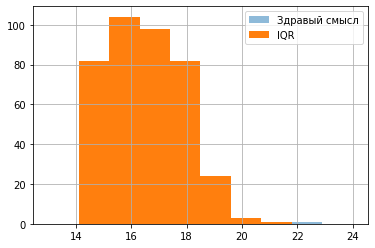

In [7]:
print_column_hist(df[col_name], (15,22))

У признака приблизительно нормальное распределение (форма гистограммы, среднее близко к медиане). Распределение смещено в сторону возрастов 16-19. Если пользоваться критерием интерквартильного расстояния, то значения выше 21 являются выбросами (1 значение в колонке). С другой стороны, переменная возраста может принимать значения от 15 до 22, поэтому нет необходимости устранять этот выброс. Данные в колонке пригодны для дальнейшего анализа.

# 4. Address — тип адреса ('U', 'R')
Проверим данные на корректность значений.

In [8]:
col_name = 'address'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('U', 'R'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
U,295,78.0
R,83,22.0


378

Количество пропусков: 17
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 5. Famsize — размер семьи ('LE3', 'GT3')
Проверим данные на корректность значений.

In [9]:
col_name = 'famsize'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('LE3', 'GT3'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
GT3,261,70.9
LE3,107,29.1


368

Количество пропусков: 27
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 6. Pstatus — статус совместного жилья родителей ('T', 'A')
Проверим данные на корректность значений.

In [10]:
col_name = 'pstatus'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('T', 'A'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
T,314,89.7
A,36,10.3


350

Количество пропусков: 45
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 7. Medu — образование матери (0 - 4)
Проверим данные на корректность значений.

In [11]:
col_name = 'medu'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(5))
# df[col_name] = df[col_name].astype('int64')


print_column_info(df[col_name])

Данные корректны.


,Num,%
4.0,131,33.4
2.0,102,26.0
3.0,97,24.7
1.0,59,15.1
0.0,3,0.8


392

Количество пропусков: 3
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


# 8. Fedu — образование отца (0 - 4)
Проверим данные на корректность значений.

In [12]:
col_name = 'fedu'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(5))
# df[col_name] = df[col_name].astype('int64')

print_column_info(df[col_name])

Данные не корректны: 40.0    1
Name: fedu, dtype: int64


,Num,%
2.0,106,28.6
3.0,96,25.9
4.0,88,23.7
1.0,78,21.0
0.0,2,0.5
40.0,1,0.3


371

Количество пропусков: 24
Количество уникальных значений: 6
Количество значений, встретившихся более 10 раз: 4


In [13]:
df[col_name].replace(40, 4, inplace=True)
check_discrete_values(df[col_name], range(5))

print_column_info(df[col_name])

Данные корректны.


,Num,%
2.0,106,28.6
3.0,96,25.9
4.0,89,24.0
1.0,78,21.0
0.0,2,0.5


371

Количество пропусков: 24
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


# 9. Mjob — работа матери ('teacher', 'health', 'services', 'at_home', 'other') 

In [14]:
col_name = 'mjob'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('teacher','health','services','at_home','other'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
other,133,35.4
services,98,26.1
at_home,58,15.4
teacher,55,14.6
health,32,8.5


376

Количество пропусков: 19
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 10. Fjob — работа отца ('teacher', 'health', 'services', 'at_home', 'other') 

In [15]:
col_name = 'fjob'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('teacher','health','services','at_home','other'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
other,197,54.9
services,102,28.4
teacher,29,8.1
at_home,16,4.5
health,15,4.2


359

Количество пропусков: 36
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 11. Reason — причина выбора школы ('home', 'reputation', 'course', 'other')

In [16]:
col_name = 'reason'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('home','reputation','course','other'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
course,137,36.2
home,104,27.5
reputation,103,27.2
other,34,9.0


378

Количество пропусков: 17
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


# 12. Guardian — опекун ('mother', 'father', 'other')

In [17]:
col_name = 'guardian'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('mother','father','other'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
mother,250,68.7
father,86,23.6
other,28,7.7


364

Количество пропусков: 31
Количество уникальных значений: 3
Количество значений, встретившихся более 10 раз: 3


# 13. Traveltime — время в пути до школы (1 - 4)

In [18]:
col_name = 'traveltime'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(1,5))
# df[col_name] = df[col_name].astype('int64')

print_column_info(df[col_name])

Данные корректны.


,Num,%
1.0,242,65.9
2.0,96,26.2
3.0,22,6.0
4.0,7,1.9


367

Количество пропусков: 28
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 3


# 14. Studytime — время на учёбу помимо школы в неделю (1 - 4)

In [19]:
col_name = 'studytime'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(1,5))
# df[col_name] = df[col_name].astype('int64')

print_column_info(df[col_name])

Данные корректны.


,Num,%
2.0,194,50.0
1.0,103,26.5
3.0,64,16.5
4.0,27,7.0


388

Количество пропусков: 7
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


# 14.1 Studytime, granular - без описания

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


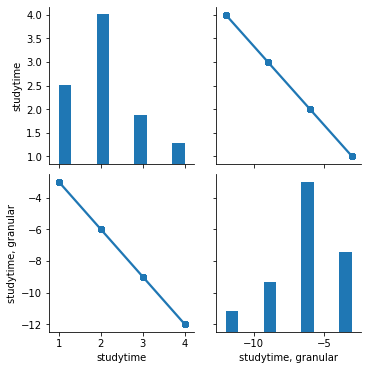

In [20]:
test_columns = ['studytime', 'studytime, granular']
sns.pairplot(df[test_columns], kind = 'reg')
df[test_columns].corr()

In [21]:
df.drop(['studytime, granular'], inplace = True, axis = 1)

# 15. Failures — количество внеучебных неудач (0 - 3)

In [22]:
col_name = 'failures'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(4))
# df[col_name] = df[col_name].astype('int64')

print_column_info(df[col_name])

Данные корректны.


,Num,%
0.0,293,78.6
1.0,49,13.1
2.0,16,4.3
3.0,15,4.0


373

Количество пропусков: 22
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


# 16. Schoolsup — дополнительная образовательная поддержка ('yes', 'no')

In [23]:
col_name = 'schoolsup'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
no,335,86.8
yes,51,13.2


386

Количество пропусков: 9
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 17. Famsup — семейная образовательная поддержка ('yes', 'no')

In [24]:
col_name = 'famsup'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
yes,219,61.5
no,137,38.5


356

Количество пропусков: 39
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 18. Paid — дополнительные платные занятия по математике ('yes', 'no')

In [25]:
col_name = 'paid'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
no,200,56.3
yes,155,43.7


355

Количество пропусков: 40
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 19. Activities — дополнительные внеучебные занятия ('yes', 'no')

In [26]:
col_name = 'activities'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
yes,195,51.2
no,186,48.8


381

Количество пропусков: 14
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 20. Nursery — посещал детский сад ('yes', 'no')

In [27]:
col_name = 'nursery'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
yes,300,79.2
no,79,20.8


379

Количество пропусков: 16
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 21. Higher — хочет получить высшее образование ('yes', 'no')

In [28]:
col_name = 'higher'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
yes,356,94.9
no,19,5.1


375

Количество пропусков: 20
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 22. Internet — наличие интернета дома ('yes', 'no')

In [29]:
col_name = 'internet'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
yes,305,84.5
no,56,15.5


361

Количество пропусков: 34
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 23. Romantic — в романтических отношениях ('yes', 'no')

In [30]:
col_name = 'romantic'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Num,%
no,240,65.9
yes,124,34.1


364

Количество пропусков: 31
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 24. Famrel — семейные отношения (1 - 5)

In [31]:
col_name = 'famrel'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(1,6))
df[col_name].replace(-1, 1, inplace=True)
# df[col_name] = df[col_name].astype('int64')

check_discrete_values(df[col_name], range(1,6))

print_column_info(df[col_name])

Данные не корректны: -1.0    1
Name: famrel, dtype: int64
Данные корректны.


,Num,%
4.0,182,49.5
5.0,99,26.9
3.0,62,16.8
2.0,17,4.6
1.0,8,2.2


368

Количество пропусков: 27
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


# 25. Freetime — свободное время после школы (1 - 5)

In [32]:
col_name = 'freetime'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(1,6))
# df[col_name] = df[col_name].astype('int64')


print_column_info(df[col_name])

Данные корректны.


,Num,%
3.0,153,39.8
4.0,112,29.2
2.0,63,16.4
5.0,38,9.9
1.0,18,4.7


384

Количество пропусков: 11
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 26. Goout — проведение времени с друзьями (1 - 5)

In [33]:
col_name = 'goout'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(1,6))
# df[col_name] = df[col_name].astype('int64')

print_column_info(df[col_name])

Данные корректны.


,Num,%
3.0,127,32.8
2.0,101,26.1
4.0,84,21.7
5.0,52,13.4
1.0,23,5.9


387

Количество пропусков: 8
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 27. Health — текущее состояние здоровья (1 - 5)

In [34]:
col_name = 'health'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(1,6))
# df[col_name] = df[col_name].astype('int64')

print_column_info(df[col_name])

Данные корректны.


,Num,%
5.0,138,36.3
3.0,89,23.4
4.0,63,16.6
1.0,47,12.4
2.0,43,11.3


380

Количество пропусков: 15
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 28. Absences — количество пропущенных занятий

In [35]:
col_name = 'absences'
# df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_continuous_values(df[col_name], (0,365))
df = remove_value(df, col_name, 385)
# df[col_name] = df[col_name].astype('int64')


check_continuous_values(df[col_name], (0,365))
check_discrete_values(df[col_name], range(366))

print_column_info(df[col_name])

Данные не корректны: 385.0    1
Name: absences, dtype: int64
Данные корректны.
Данные корректны.


,Num,%
0.0,111,29.1
2.0,60,15.7
4.0,53,13.9
6.0,31,8.1
8.0,21,5.5
10.0,17,4.5
12.0,12,3.1
14.0,12,3.1
3.0,8,2.1
16.0,7,1.8


... other values


382

Количество пропусков: 12
Количество уникальных значений: 35
Количество значений, встретившихся более 10 раз: 8


count    382.000000
mean       6.290576
std       13.289503
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      212.000000
Name: absences, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 8.0 
IQR: 8.0, Границы выбросов: [-12.0, 20.0].


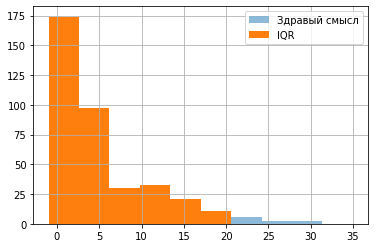

In [36]:
print_column_hist(df[col_name], (0,365), (-1,35))

До 30

In [37]:
df = df[df[col_name] <= 30]
df[col_name].describe()

count    376.000000
mean       5.127660
std        5.854656
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       30.000000
Name: absences, dtype: float64

# 29. Score — баллы по госэкзамену по математике

In [38]:
col_name = 'score'
df = df[~(df[col_name].isnull() | df[col_name].isna())]

check_discrete_values(df[col_name], range(101))
df[col_name] = df[col_name].astype('int64')

print_column_info(df[col_name])

Данные корректны.


,Num,%
50,53,14.3
55,44,11.9
0,36,9.7
75,31,8.4
65,31,8.4
60,29,7.8
70,27,7.3
40,27,7.3
45,25,6.7
80,16,4.3


... other values


371

Количество пропусков: 0
Количество уникальных значений: 18
Количество значений, встретившихся более 10 раз: 12


count    371.00000
mean      52.03504
std       22.92989
min        0.00000
25%       40.00000
50%       55.00000
75%       70.00000
max      100.00000
Name: score, dtype: float64

25-й перцентиль: 40.0, 75-й перцентиль: 70.0 
IQR: 30.0, Границы выбросов: [-5.0, 115.0].


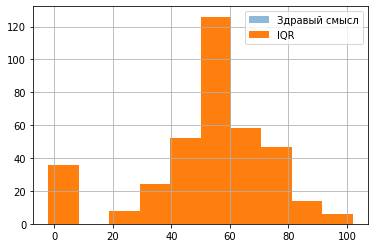

In [39]:
print_column_hist(df[col_name], (0,100))

# Корреляционный анализ

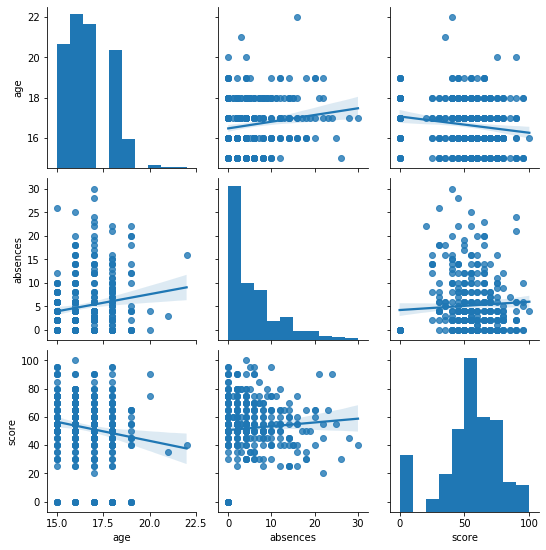

In [40]:
numeric_columns = ['age', 'absences', 'score'] 
sns.pairplot(df[numeric_columns], kind = 'reg')

In [41]:
df[numeric_columns].corr()

,age,absences,score
age,1.000000,0.155755,-0.147750
absences,0.155755,1.000000,0.068886
score,-0.147750,0.068886,1.000000


# Анализ номинативных переменных

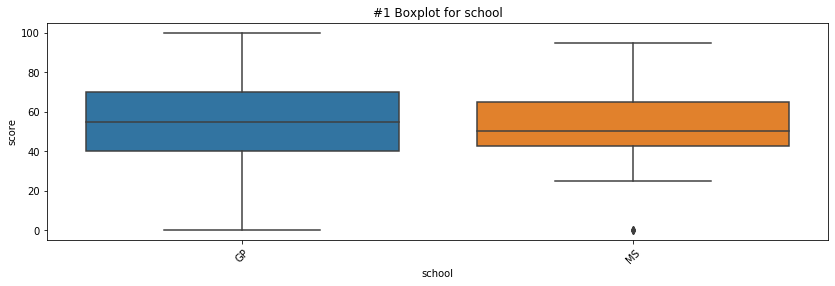

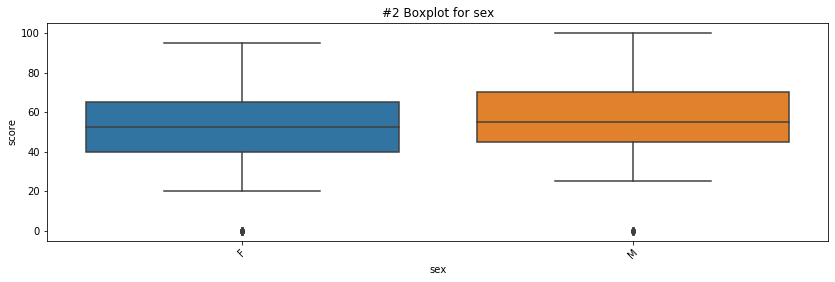

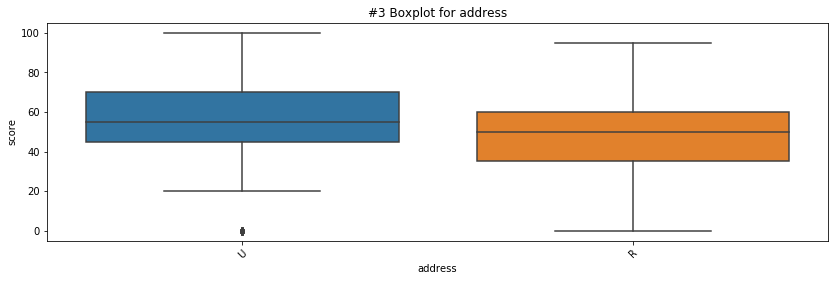

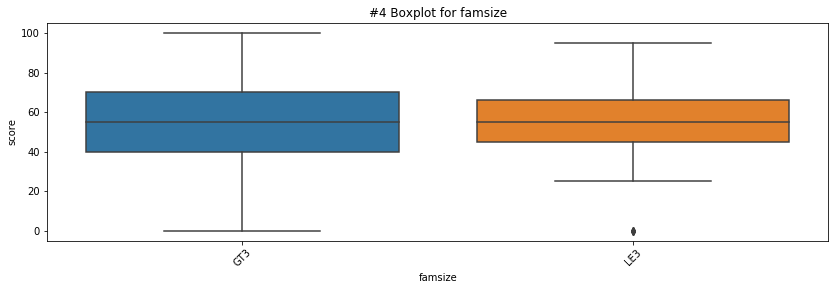

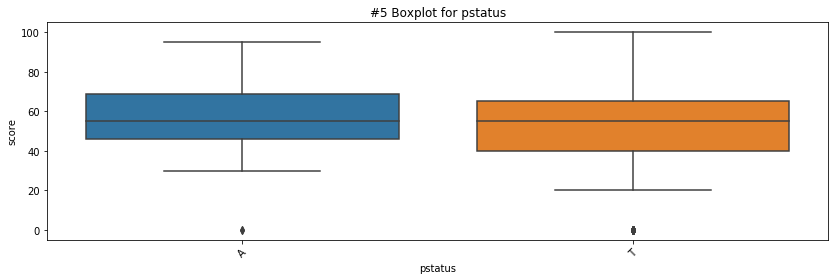

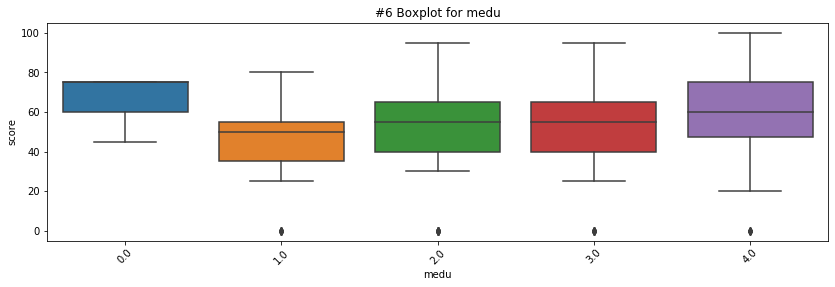

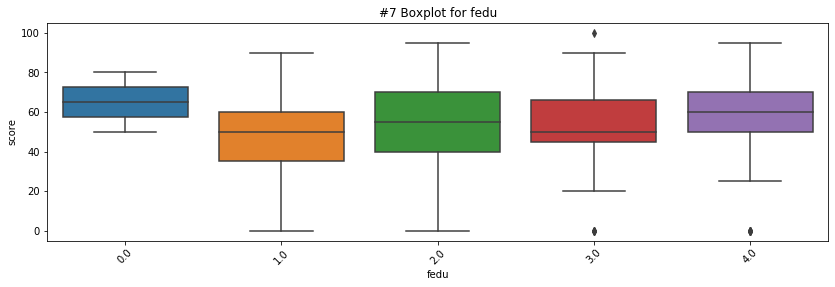

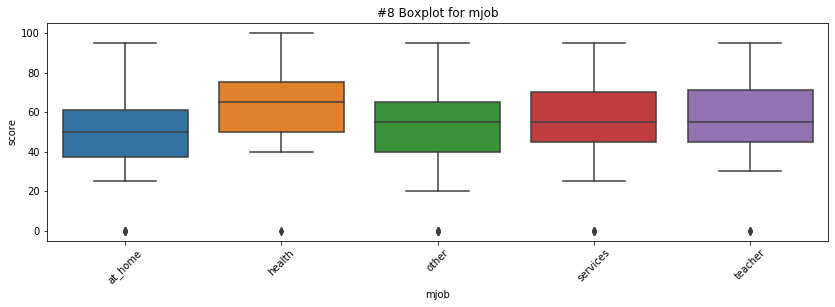

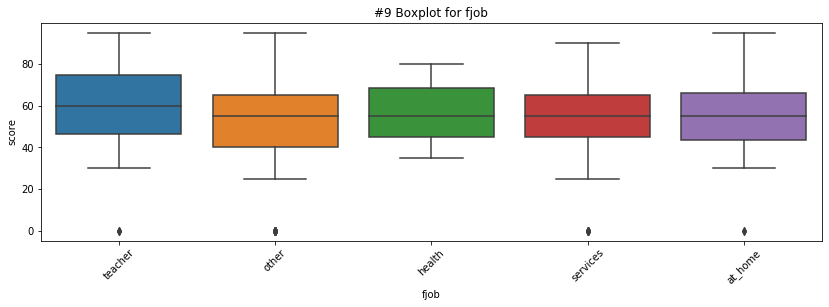

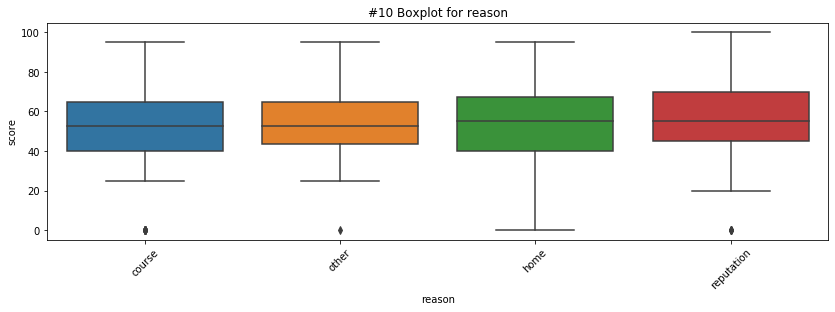

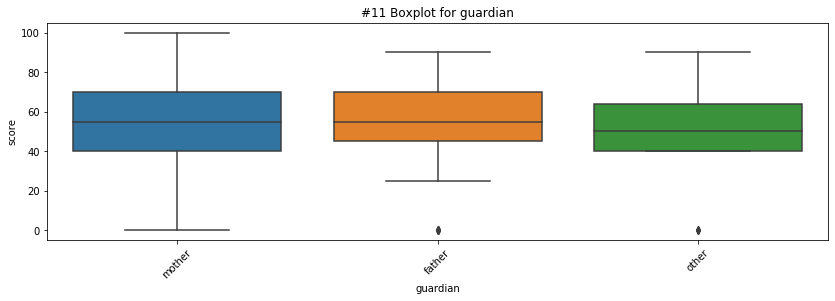

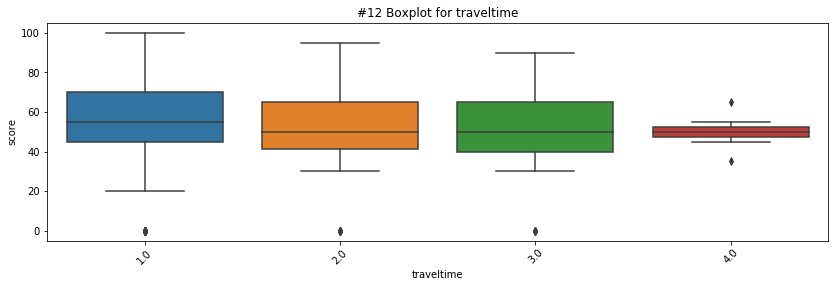

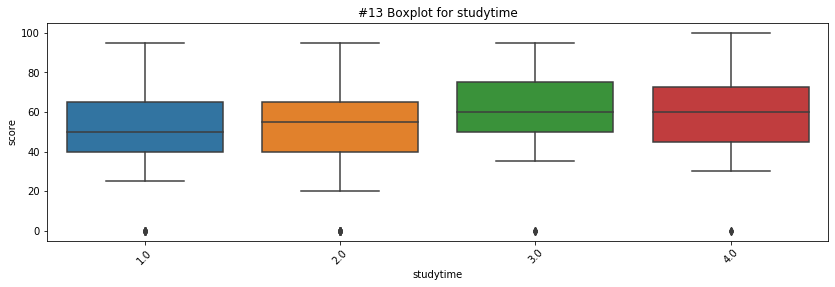

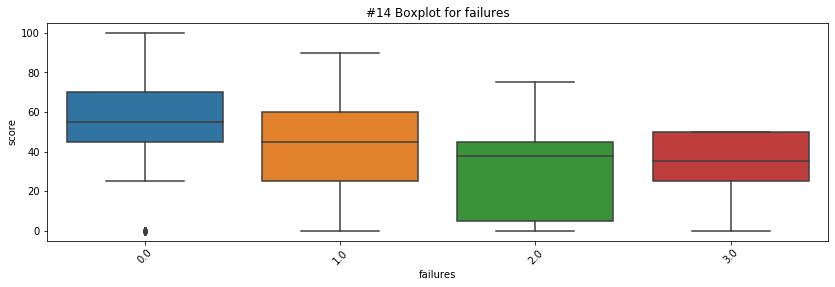

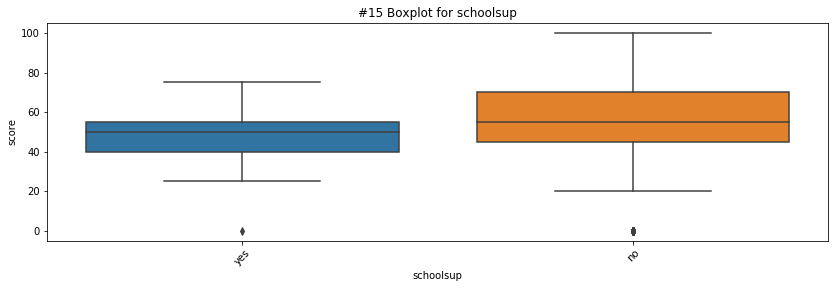

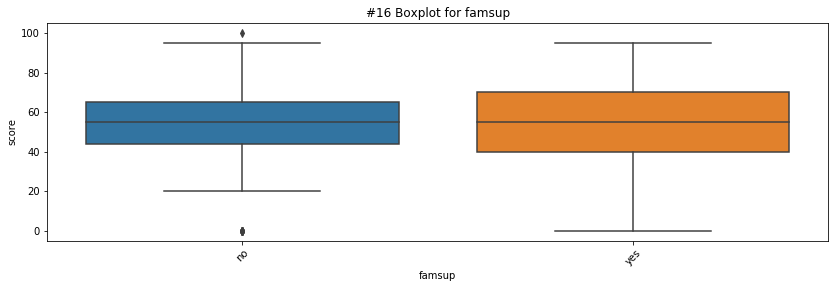

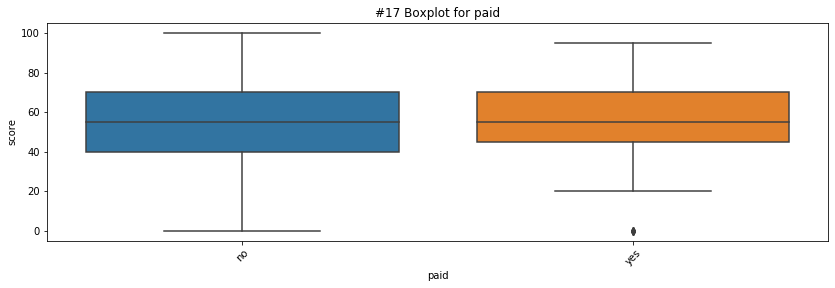

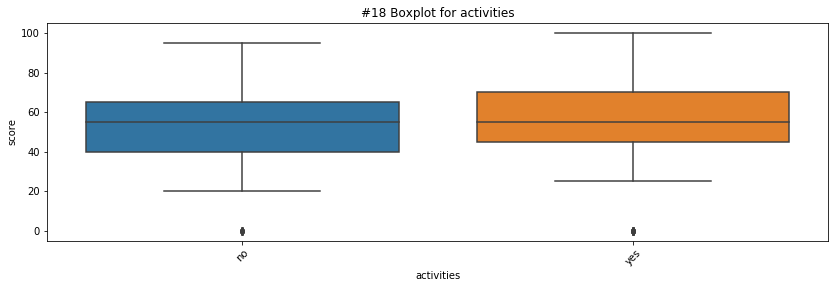

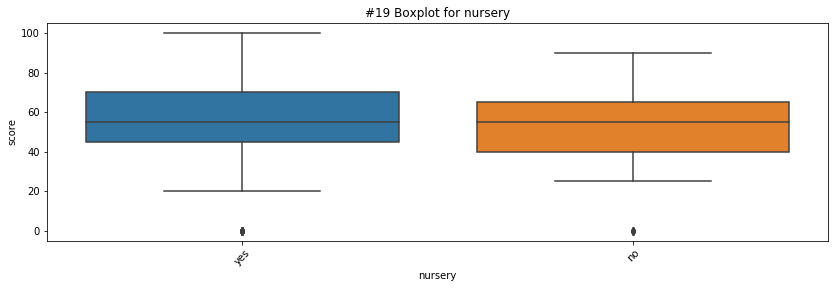

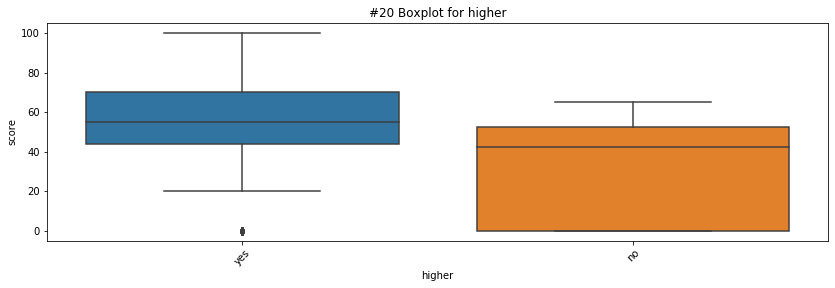

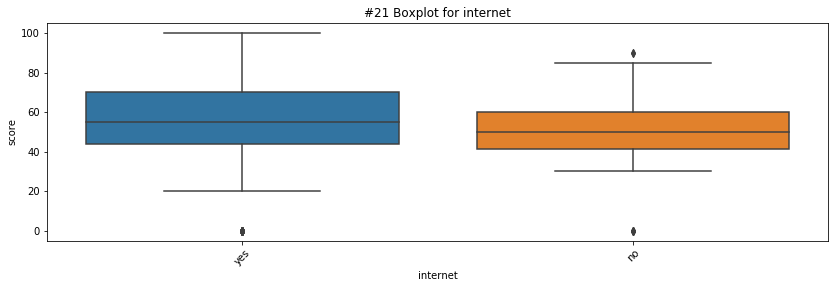

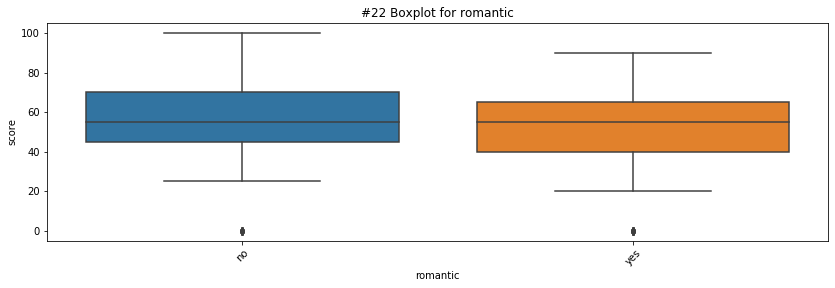

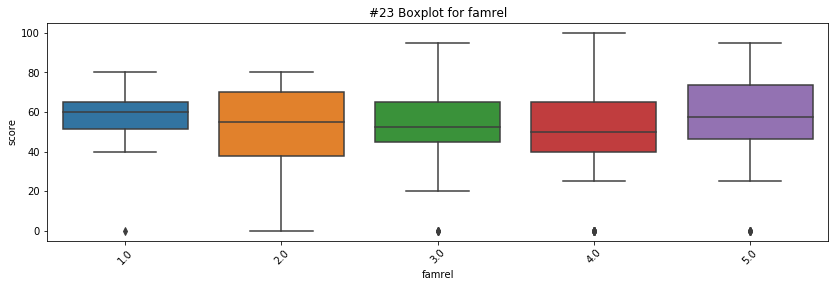

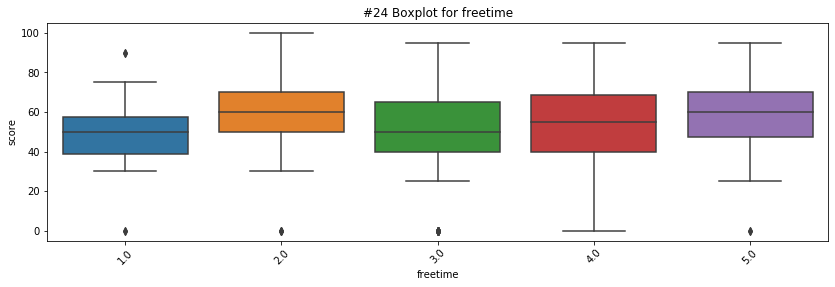

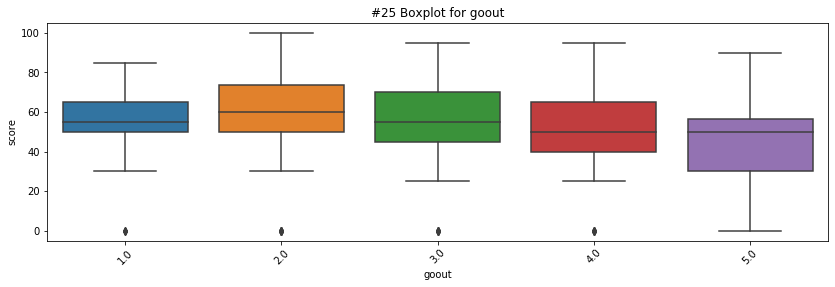

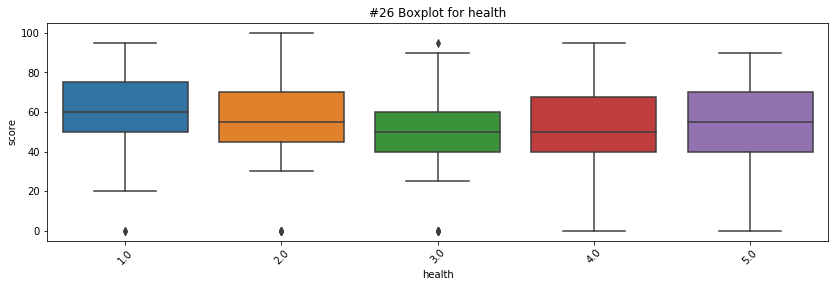

In [42]:
counter = 0
for col_name in df.columns:
    if not col_name in numeric_columns:
        counter += 1
        get_boxplot(df, col_name, counter)

In [43]:
for col_name in df.columns:
    if (not col_name in numeric_columns) and (col_name != 'sex'):
        print('Curr: ' + col_name)
        get_stat_dif(df, col_name)

Curr: school
Curr: address
Найдены статистически значимые различия для колонки address
Curr: famsize
Curr: pstatus
Curr: medu
Найдены статистически значимые различия для колонки medu
Curr: fedu
Curr: mjob
Найдены статистически значимые различия для колонки mjob
Curr: fjob
Curr: reason
Curr: guardian
Curr: traveltime
Curr: studytime
Curr: failures
Найдены статистически значимые различия для колонки failures
Curr: schoolsup
Curr: famsup
Curr: paid
Curr: activities
Curr: nursery
Curr: higher
Найдены статистически значимые различия для колонки higher
Curr: internet
Curr: romantic
Найдены статистически значимые различия для колонки romantic
Curr: famrel
Curr: freetime
Curr: goout
Найдены статистически значимые различия для колонки goout
Curr: health


In [44]:
display(df.isnull().sum().sum())
display(df.isna().sum().sum())
display(df.dtypes)

512

512

school         object
sex            object
age             int64
address        object
famsize        object
pstatus        object
medu          float64
fedu          float64
mjob           object
fjob           object
reason         object
guardian       object
traveltime    float64
studytime     float64
failures      float64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel        float64
freetime      float64
goout         float64
health        float64
absences      float64
score           int64
dtype: object